In [1]:
from IPython.display import clear_output


# !pip install tensorflow
# !pip install  spacy
# !pip install tqdm
# !pip install plotly
!pip install jupyter-black
!pip install imblearn


# clear_output()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 64.0 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


## Data preprocessing

### Import libraries

In [2]:
import csv
import re
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm

tqdm.pandas()

In [3]:
%load_ext jupyter_black

In [4]:
np.set_printoptions(precision=4)

### Import data

In [5]:
path = "data/"
# Read sequences
sequences = list()
with open(path + "sequences.txt", "r") as f:
    for line in f:
        sequences.append(line[:-1])

# Split data into training and test sets
sequences_train = list()
sequences_test = list()
proteins_test = list()
train_target = list()
with open(path + "graph_labels.txt", "r") as f:
    for i, line in enumerate(f):
        t = line.split(",")
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            sequences_test.append(sequences[i])
        else:
            sequences_train.append(sequences[i])
            train_target.append(int(t[1][:-1]))

sequences_train = np.array(sequences_train)
train_target = np.array(train_target)
sequences_test = np.array(sequences_test)

In [6]:
data = pd.DataFrame({"seq": sequences_train, "target": train_target})

In [7]:
unseen = pd.DataFrame({"seq": sequences_test})

<AxesSubplot:>

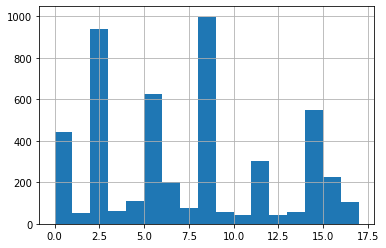

In [8]:
data.target.hist(bins=17)

In [9]:
mean_carr = np.mean(data.seq.progress_apply(len))
std_carr = np.std(data.seq.progress_apply(len))
print(mean_carr)
print("mean", mean_carr, "and std is", std_carr)

  0%|          | 0/4888 [00:00<?, ?it/s]

  0%|          | 0/4888 [00:00<?, ?it/s]

258.14279869067104
mean 258.14279869067104 and std is 162.24346887570542


We notice that the target isn't balanced, so we will take that into consideration by :
- adding sample weight in logistic regression and the other models that supports weight to impact directly the loss function
- we can make an oversampling using duplication which is poor or using smote (that add some guassian noise )
- we can make an undersampling by reducing the number of majority class samples

### Important functions 

In [10]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x


softmax_vect = np.vectorize(softmax)

In [11]:
# weighted multi-class log loss
from sklearn.metrics import log_loss


def weighted_mc_log_loss(y_true, y_pred, y_pred_proba):
    loss = log_loss(y_true, y_pred_proba, labels=np.unique(y_true))
    accuracy = round((y_true == y_pred).sum() / len(y_true) * 100, 2)
    return print(f"{loss = } and accuracy {accuracy = }")

In [12]:
def submit(y_pred_proba):
    # Write predictions to a file
    with open("../Submissions/sample_submission.csv", "w") as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        lst = list()
        for i in range(18):
            lst.append("class" + str(i))
        lst.insert(0, "name")
        writer.writerow(lst)
        for i, protein in enumerate(proteins_test):
            lst = y_pred_proba[i, :].tolist()
            lst.insert(0, protein)
            writer.writerow(lst)

### Split data

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data,  # Features
    data.target.to_numpy(),  # Target variable
    test_size=0.2,  # 20% test size
)
X_train = X_train.reset_index(drop=True)  # we reste the indexes
X_test = X_test.reset_index(drop=True)

# using structure

In [14]:
import time
import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim


def load_data():
    """
    Function that loads graphs
    """
    graph_indicator = np.loadtxt(path + "graph_indicator.txt", dtype=np.int64)
    _, graph_size = np.unique(graph_indicator, return_counts=True)

    edges = np.loadtxt(path + "edgelist.txt", dtype=np.int64, delimiter=",")
    edges_inv = np.vstack((edges[:, 1], edges[:, 0]))
    edges = np.vstack((edges, edges_inv.T))
    s = edges[:, 0] * graph_indicator.size + edges[:, 1]
    idx_sort = np.argsort(s)
    edges = edges[idx_sort, :]
    edges, idx_unique = np.unique(edges, axis=0, return_index=True)
    A = sp.csr_matrix(
        (np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
        shape=(graph_indicator.size, graph_indicator.size),
    )

    x = np.loadtxt(path + "node_attributes.txt", delimiter=",")
    edge_attr = np.loadtxt(path + "edge_attributes.txt", delimiter=",")
    edge_attr = np.vstack((edge_attr, edge_attr))
    edge_attr = edge_attr[idx_sort, :]
    edge_attr = edge_attr[idx_unique, :]

    adj = []
    features = []
    edge_features = []
    idx_n = 0
    idx_m = 0
    for i in range(graph_size.size):
        adj.append(A[idx_n : idx_n + graph_size[i], idx_n : idx_n + graph_size[i]])
        edge_features.append(edge_attr[idx_m : idx_m + adj[i].nnz, :])
        features.append(x[idx_n : idx_n + graph_size[i], :])
        idx_n += graph_size[i]
        idx_m += adj[i].nnz

    return adj, features, edge_features

In [15]:
def normalize_adjacency(A):
    """
    Function that normalizes an adjacency matrix
    """
    n = A.shape[0]
    A += sp.identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs, -1)
    D = sp.diags(inv_degs)
    A_normalized = D.dot(A)

    return A_normalized


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """
    Function that converts a Scipy sparse matrix to a sparse Torch tensor
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)
    )
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [16]:
# Load graphs
adj, features, edge_features = load_data()

# Normalize adjacency matrices
adj = [normalize_adjacency(A) for A in adj]

# Split data into training and test sets
adj_train = list()
features_train = list()
y_train = list()
adj_test = list()
features_test = list()
proteins_test = list()

In [17]:
with open(path + "graph_labels.txt", "r") as f:
    for i, line in enumerate(f):
        t = line.split(",")
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            adj_test.append(adj[i])
            features_test.append(features[i])
        else:
            adj_train.append(adj[i])
            features_train.append(features[i])
            y_train.append(int(t[1][:-1]))

In [19]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [47]:
class GNN(nn.Module):
    """
    Simple message passing model that consists of 2 message passing layers
    and the sum aggregation function
    """

    def __init__(self, input_dim, hidden_dim, dropout, n_class):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, n_class)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_in, adj, idx):
        # first message passing layer
        x = self.fc1(x_in)
        x = self.relu(torch.mm(adj, x))
        x = self.dropout(x)

        # second message passing layer
        x = self.fc2(x)
        x = self.relu(torch.mm(adj, x))

        # sum aggregator
        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx) + 1, x.size(1)).to(x_in.device)
        out = out.scatter_add_(0, idx, x)

        # batch normalization layer
        out = self.bn(out)

        # mlp to produce output
        out = self.relu(self.fc3(out))
        out = self.dropout(out)
        out = self.fc4(out)

        return F.log_softmax(out, dim=1)

In [48]:
# Hyperparameters
epochs = 100
batch_size = 64
n_hidden = 128
# n_input = 86
dropout = 0.2
learning_rate = 0.0001
n_class = 18

# Compute number of training and test samples
N_train = len(adj_train)
N_test = len(adj_test)

# Initializes model and optimizer
model = GNN(n_input, n_hidden, dropout, n_class).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [49]:
# train set
adj_train_g = adj_train[:4400].copy()
features_train_g = features_train[:4400].copy()
y_train_g = y_train[:4400].copy()
# validation
adj_val_g = adj_train[4400:].copy()
features_val_g = features_train[4400:].copy()
y_val_g = y_train[4400:].copy()

In [50]:
def train_gnn(adj_train, features_train, y_train, adj_val, features_val, y_val):
    # Train model
    N_train = len(adj_train)
    min_val_loss = float("inf")
    for epoch in range(epochs):
        t = time.time()
        model.train()
        train_loss = 0
        correct = 0
        count = 0
        # Iterate over the batches
        for i in range(0, N_train, batch_size):
            adj_batch = list()
            features_batch = list()
            idx_batch = list()
            y_batch = list()

            # Create tensors
            for j in range(i, min(N_train, i + batch_size)):
                n = adj_train[j].shape[0]
                adj_batch.append(adj_train[j] + sp.identity(n))
                features_batch.append(features_train[j])
                idx_batch.extend([j - i] * n)
                y_batch.append(y_train[j])

            adj_batch = sp.block_diag(adj_batch)
            features_batch = np.vstack(features_batch)

            adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch).to(device)
            features_batch = torch.FloatTensor(features_batch).to(device)
            idx_batch = torch.LongTensor(idx_batch).to(device)
            y_batch = torch.LongTensor(y_batch).to(device)

            optimizer.zero_grad()
            output = model(features_batch, adj_batch, idx_batch)
            loss = loss_function(output, y_batch)
            train_loss += loss.item() * output.size(0)
            count += output.size(0)
            preds = output.max(1)[1].type_as(y_batch)
            correct += torch.sum(preds.eq(y_batch).double())
            loss.backward()
            optimizer.step()

        if epoch % 3 == 0:
            # Evaluate model
            model.eval()
            y_pred_proba, y_pred = predict_test(adj_val, features_val, model)
            val_loss = log_loss(y_val, y_pred_proba, labels=np.unique(y_val))
            print(
                "Epoch: {:03d}".format(epoch + 1),
                "loss_train: {:.4f}".format(train_loss / count),
                "acc_train: {:.4f}".format(correct / count),
                "time: {:.4f}s".format(time.time() - t),
                "log_loss_val: {:.4f}".format(val_loss),
            )
            if min_val_loss > val_loss:
                print(
                    f"Validation Loss Decreased({min_val_loss:.6f}--->{val_loss:.6f}) \t Saving The Model"
                )
                min_val_loss = val_loss
                # Saving State Dict
                # torch.save(model.state_dict(), "saved_model.pth")
            else:
                print("Validation loss increased :(")

In [51]:
def predict_test(adj_test, features_test, model):
    y_pred_proba = list()
    for i in range(0, len(adj_test), batch_size):
        adj_batch = list()
        idx_batch = list()
        features_batch = list()
        y_batch = list()

        # Create tensors
        for j in range(i, min(len(adj_test), i + batch_size)):
            n = adj_test[j].shape[0]
            adj_batch.append(adj_test[j] + sp.identity(n))
            features_batch.append(features_test[j])
            idx_batch.extend([j - i] * n)

        adj_batch = sp.block_diag(adj_batch)
        features_batch = np.vstack(features_batch)

        adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch).to(device)
        features_batch = torch.FloatTensor(features_batch).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)

        output = model(features_batch, adj_batch, idx_batch)
        y_pred_proba.append(output)

    y_pred_proba = torch.cat(y_pred_proba, dim=0)
    y_pred_proba = torch.exp(y_pred_proba)
    y_pred_proba = y_pred_proba.detach().cpu().numpy()
    y_pred = y_pred_proba.argmax(axis=1)
    return y_pred_proba, y_pred

In [52]:
# model.load_state_dict(torch.load("/notebooks/build model/gnn_model.pth"))
# model.eval()


In [53]:
train_gnn(adj_train_g, features_train_g, y_train_g, adj_val_g, features_val_g, y_val_g)

Epoch: 001 loss_train: 2.7649 acc_train: 0.1734 time: 4.9462s log_loss_val: 2.8207
Validation Loss Decreased(inf--->2.820666) 	 Saving The Model
Epoch: 004 loss_train: 2.3972 acc_train: 0.2757 time: 4.6507s log_loss_val: 2.5825
Validation Loss Decreased(2.820666--->2.582456) 	 Saving The Model
Epoch: 007 loss_train: 2.2505 acc_train: 0.3291 time: 4.7275s log_loss_val: 2.5054
Validation Loss Decreased(2.582456--->2.505446) 	 Saving The Model
Epoch: 010 loss_train: 2.0762 acc_train: 0.3934 time: 4.8641s log_loss_val: 2.4792
Validation Loss Decreased(2.505446--->2.479188) 	 Saving The Model
Epoch: 013 loss_train: 1.9421 acc_train: 0.4343 time: 4.6025s log_loss_val: 2.4504
Validation Loss Decreased(2.479188--->2.450377) 	 Saving The Model
Epoch: 016 loss_train: 1.8545 acc_train: 0.4550 time: 4.7616s log_loss_val: 2.3878
Validation Loss Decreased(2.450377--->2.387797) 	 Saving The Model
Epoch: 019 loss_train: 1.7756 acc_train: 0.4750 time: 4.5987s log_loss_val: 2.3862
Validation Loss Decrea

In [31]:
GNN_proba, GNN_pred = predict_test(adj_test, features_test, model)

In [34]:
submit(GNN_proba)

In [48]:
weighted_mc_log_loss(y_val_g, GNN_pred, GNN_proba)

loss = 1.6898060926918796 and accuracy accuracy = 55.12


In [62]:
features_svm = np.array([features.mean(0) for features in features_train])

In [64]:
features_train_svm = features_svm[:4400]
features_test_svm = features_svm[4400:]
y_train_g, y_test_g = y_train[:4400], y_train[4400:]

In [67]:
from sklearn.svm import SVC

svc = SVC(kernel="rbf", probability=True)
svc.fit(features_train_svm, y_train_g)

SVC(probability=True)

In [71]:
y_pred_proba = svc.predict_proba(features_test_svm)
y_pred = svc.predict(features_test_svm)
weighted_mc_log_loss(y_test_g, y_pred, y_pred_proba)

loss = 2.275820301830954 and accuracy accuracy = 19.06


In [69]:
# weighted multi-class log loss
from sklearn.metrics import log_loss


def weighted_mc_log_loss(y_true, y_pred, y_pred_proba):
    loss = log_loss(y_true, y_pred_proba, labels=np.unique(y_true))
    accuracy = round((y_true == y_pred).sum() / len(y_true) * 100, 2)
    return print(f"{loss = } and accuracy {accuracy = }")